<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-06/Conditional%20GAN%20(CGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import useful libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.1


# Download and show data

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


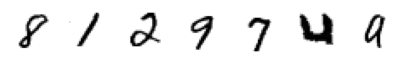

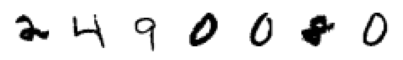

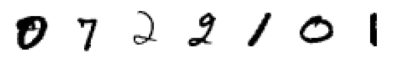

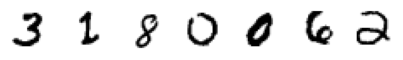

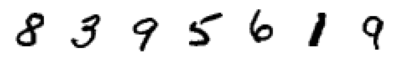

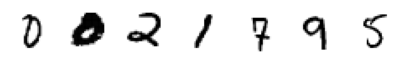

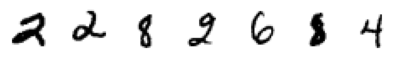

In [5]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

for k in range(7):
    plt.figure(figsize=(7, 7))
    for j in range(7):
        i = np.random.randint(0, 10000)
        plt.subplot(770 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
    plt.show()

# 10 classes

In [6]:
#Ten classes
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

# data normalization

In [7]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Define Generator Model

In [8]:
random_input = tensorflow.keras.layers.Input(shape = 100)
class_input = tensorflow.keras.layers.Input(shape = 10)

x1 = tensorflow.keras.layers.Dense(5*5*4)(random_input)
x1 = tensorflow.keras.layers.Activation('relu')(x1)
x1 = tensorflow.keras.layers.Reshape((5, 5, 4))(x1)

#Class Input
x2 = tensorflow.keras.layers.Dense(25)(class_input)
x2 = tensorflow.keras.layers.Activation('relu')(x2)
x2 = tensorflow.keras.layers.Reshape((5, 5, 1))(x2)

x = tensorflow.keras.layers.Concatenate()([x1, x2])

x = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('relu')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('relu')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(8,8))(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=[random_input, class_input], outputs=generated_image)
generator_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          10100       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 25)           275         input_2[0][0]                    
______________________________________________________________________________________________

# Define Discriminator

In [9]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))
class_input = tensorflow.keras.layers.Input(shape = 10)

#Class Input
x2 = tensorflow.keras.layers.Dense(28*28)(class_input)
x2 = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x2)
x2 = tensorflow.keras.layers.Reshape((28, 28, 1))(x2)

x = tensorflow.keras.layers.Concatenate()([image_input, x2])

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3))(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Flatten()(x)

x = tensorflow.keras.layers.Dense(1)(x)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=[image_input, class_input], outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 784)          8624        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 784)          0           dense_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
____________________________________________________________________________________________

In [10]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Define combined model: CGAN

In [12]:
discriminator_network.trainable=False
gan_input = generator_network([random_input, class_input])
gan_output = discriminator_network([gan_input, class_input])

gan_model = tensorflow.keras.models.Model([random_input, class_input], gan_output)
gan_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 28, 28, 1)    629448      input_1[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            270641      model[0][0]                

# Compiling CGAN

In [13]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

# Define Utility Functions

In [14]:
indices = [i for i in range(0, len(trainX))]

def encode_class(value):
    x = np.zeros((10))
    x[value]=1
    return x

def decode_class(value):
    return np.where(value==1)[0][0]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    class_names = []
    for i in range(batch_size):
        class_name = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=1)
        class_names.append(encode_class(class_name))
    class_names = np.array(class_names)
    return random_noise_batches, class_names

def get_fake_samples(generator_network, batch_size, noise_size, class_name=-1):
    random_noise_batches, _ = get_random_noise(batch_size, noise_size) 
    if class_name == -1:
        class_names = []
        for i in range(batch_size):
            class_name = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=1)
            class_names.append(encode_class(class_name))
        class_names = np.array(class_names)
    else:
        class_names = []
        for i in range(batch_size):
            class_names.append(encode_class(class_name))
        class_names = np.array(class_names)
           
    fake_samples = generator_network.predict_on_batch([random_noise_batches, class_names])
    return [fake_samples, class_names]

def get_real_samples(batch_size, class_names=-1):
    if class_names == -1:
        random_indices = np.random.choice(indices, size=batch_size)
        class_names = []
        for ind in random_indices:
            class_names.append(encode_class(trainY[ind]))
        
    else:
        random_indices = []
        for cls in class_names:
            ind = np.random.choice(np.where(trainY==cls), size=1)
            random_indices.append(ind)

    real_images = trainX[np.array(random_indices),:]
    return [real_images, class_names]

def show_generator_results(generator_network):
    for k in range(10):
        fake_samples = get_fake_samples(generator_network, 10, noise_size, k)
        plt.figure(figsize=(10, 6))
        for j in range(9):
            i = j
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[0][i,:,:,-1], cmap='gray_r')
            #plt.title(decode_class(fake_samples[1][i]))
            plt.axis('off')
        plt.show()
    return

# Training CGAN

In [15]:
tensorflow.config.run_functions_eagerly(True)

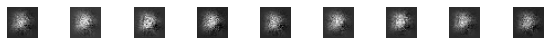

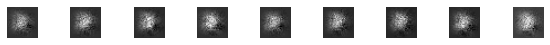

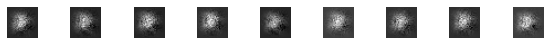

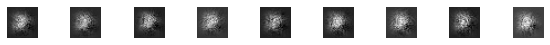

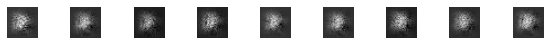

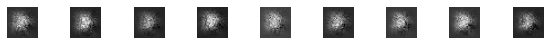

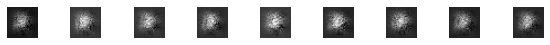

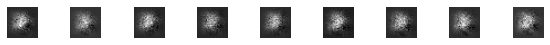

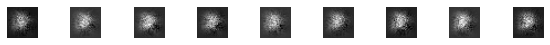

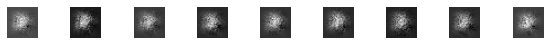

Epoch:0, Step:0, D-Loss:0.907, D-Acc:24.000, G-Loss:0.707
Epoch:0, Step:50, D-Loss:0.149, D-Acc:96.000, G-Loss:4.448
Epoch:0, Step:100, D-Loss:0.050, D-Acc:99.000, G-Loss:4.502
Epoch:0, Step:150, D-Loss:0.167, D-Acc:94.000, G-Loss:3.893
Epoch:0, Step:200, D-Loss:0.047, D-Acc:99.000, G-Loss:4.180
Epoch:0, Step:250, D-Loss:0.126, D-Acc:95.000, G-Loss:6.380
Epoch:0, Step:300, D-Loss:0.095, D-Acc:97.000, G-Loss:6.760
Epoch:0, Step:350, D-Loss:0.151, D-Acc:94.000, G-Loss:5.525
Epoch:0, Step:400, D-Loss:0.131, D-Acc:97.000, G-Loss:4.646
Epoch:0, Step:450, D-Loss:0.231, D-Acc:93.000, G-Loss:4.047
Epoch:1, Step:0, D-Loss:0.230, D-Acc:91.000, G-Loss:3.654
Epoch:1, Step:50, D-Loss:0.217, D-Acc:91.000, G-Loss:4.133
Epoch:1, Step:100, D-Loss:0.345, D-Acc:84.000, G-Loss:4.749
Epoch:1, Step:150, D-Loss:0.262, D-Acc:90.000, G-Loss:3.316
Epoch:1, Step:200, D-Loss:0.267, D-Acc:90.000, G-Loss:2.496
Epoch:1, Step:250, D-Loss:0.296, D-Acc:89.000, G-Loss:3.301
Epoch:1, Step:300, D-Loss:0.098, D-Acc:99.000,

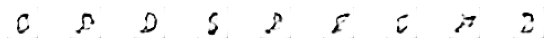

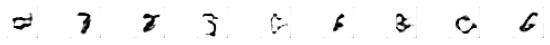

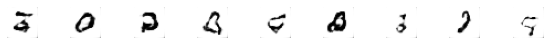

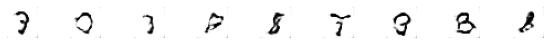

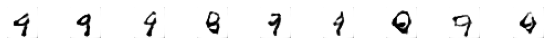

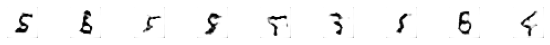

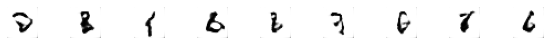

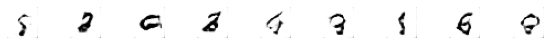

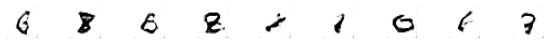

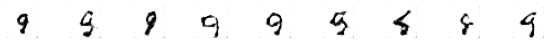

Epoch:5, Step:0, D-Loss:0.140, D-Acc:94.000, G-Loss:7.556
Epoch:5, Step:50, D-Loss:0.096, D-Acc:98.000, G-Loss:3.722
Epoch:5, Step:100, D-Loss:0.183, D-Acc:94.000, G-Loss:4.624
Epoch:5, Step:150, D-Loss:0.180, D-Acc:95.000, G-Loss:1.709
Epoch:5, Step:200, D-Loss:0.126, D-Acc:94.000, G-Loss:6.280
Epoch:5, Step:250, D-Loss:0.171, D-Acc:91.000, G-Loss:2.474
Epoch:5, Step:300, D-Loss:0.158, D-Acc:95.000, G-Loss:4.501
Epoch:5, Step:350, D-Loss:0.156, D-Acc:96.000, G-Loss:3.339
Epoch:5, Step:400, D-Loss:0.182, D-Acc:93.000, G-Loss:6.634
Epoch:5, Step:450, D-Loss:0.149, D-Acc:93.000, G-Loss:2.431
Epoch:6, Step:0, D-Loss:0.181, D-Acc:90.000, G-Loss:3.427
Epoch:6, Step:50, D-Loss:0.150, D-Acc:95.000, G-Loss:4.076
Epoch:6, Step:100, D-Loss:0.194, D-Acc:93.000, G-Loss:5.036
Epoch:6, Step:150, D-Loss:0.210, D-Acc:92.000, G-Loss:3.526
Epoch:6, Step:200, D-Loss:0.143, D-Acc:95.000, G-Loss:0.897
Epoch:6, Step:250, D-Loss:0.140, D-Acc:97.000, G-Loss:3.973
Epoch:6, Step:300, D-Loss:0.199, D-Acc:92.000,

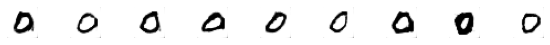

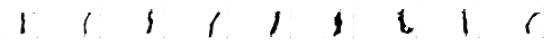

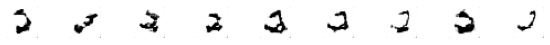

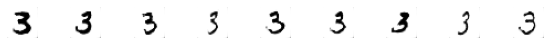

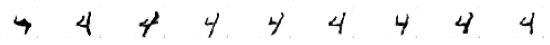

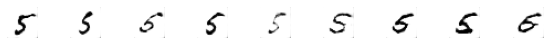

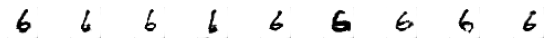

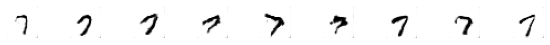

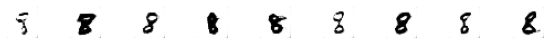

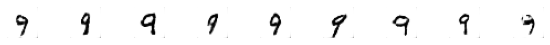

Epoch:10, Step:0, D-Loss:0.213, D-Acc:90.000, G-Loss:2.915
Epoch:10, Step:50, D-Loss:0.247, D-Acc:88.000, G-Loss:3.970
Epoch:10, Step:100, D-Loss:0.238, D-Acc:92.000, G-Loss:1.265
Epoch:10, Step:150, D-Loss:0.288, D-Acc:90.000, G-Loss:2.264
Epoch:10, Step:200, D-Loss:0.301, D-Acc:88.000, G-Loss:2.013
Epoch:10, Step:250, D-Loss:0.273, D-Acc:88.000, G-Loss:1.398
Epoch:10, Step:300, D-Loss:0.170, D-Acc:93.000, G-Loss:2.147
Epoch:10, Step:350, D-Loss:0.208, D-Acc:92.000, G-Loss:2.393
Epoch:10, Step:400, D-Loss:0.261, D-Acc:88.000, G-Loss:3.093
Epoch:10, Step:450, D-Loss:0.294, D-Acc:89.000, G-Loss:4.161
Epoch:11, Step:0, D-Loss:0.274, D-Acc:87.000, G-Loss:1.530
Epoch:11, Step:50, D-Loss:0.172, D-Acc:95.000, G-Loss:2.505
Epoch:11, Step:100, D-Loss:0.269, D-Acc:90.000, G-Loss:2.718
Epoch:11, Step:150, D-Loss:0.172, D-Acc:95.000, G-Loss:4.322
Epoch:11, Step:200, D-Loss:0.234, D-Acc:88.000, G-Loss:3.436
Epoch:11, Step:250, D-Loss:0.258, D-Acc:90.000, G-Loss:5.539
Epoch:11, Step:300, D-Loss:0.2

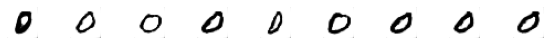

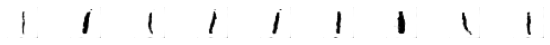

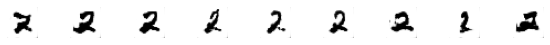

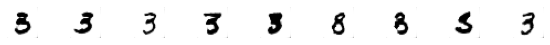

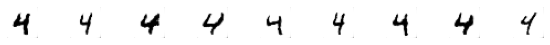

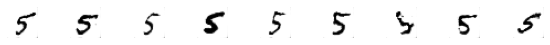

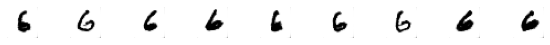

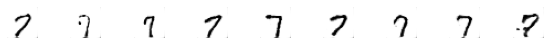

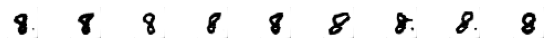

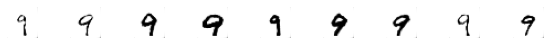

Epoch:15, Step:0, D-Loss:0.288, D-Acc:86.000, G-Loss:4.879
Epoch:15, Step:50, D-Loss:0.390, D-Acc:87.000, G-Loss:3.361
Epoch:15, Step:100, D-Loss:0.246, D-Acc:91.000, G-Loss:5.975
Epoch:15, Step:150, D-Loss:0.238, D-Acc:90.000, G-Loss:4.245
Epoch:15, Step:200, D-Loss:0.237, D-Acc:90.000, G-Loss:4.189
Epoch:15, Step:250, D-Loss:0.246, D-Acc:87.000, G-Loss:3.759
Epoch:15, Step:300, D-Loss:0.316, D-Acc:88.000, G-Loss:3.251
Epoch:15, Step:350, D-Loss:0.330, D-Acc:87.000, G-Loss:3.223
Epoch:15, Step:400, D-Loss:0.249, D-Acc:93.000, G-Loss:5.917
Epoch:15, Step:450, D-Loss:0.281, D-Acc:85.000, G-Loss:6.361
Epoch:16, Step:0, D-Loss:0.210, D-Acc:93.000, G-Loss:2.121
Epoch:16, Step:50, D-Loss:0.246, D-Acc:90.000, G-Loss:0.523
Epoch:16, Step:100, D-Loss:0.258, D-Acc:89.000, G-Loss:6.083
Epoch:16, Step:150, D-Loss:0.202, D-Acc:89.000, G-Loss:3.431
Epoch:16, Step:200, D-Loss:0.284, D-Acc:88.000, G-Loss:0.663
Epoch:16, Step:250, D-Loss:0.217, D-Acc:92.000, G-Loss:2.631
Epoch:16, Step:300, D-Loss:0.1

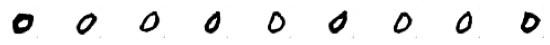

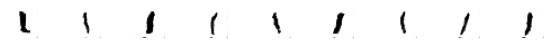

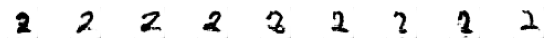

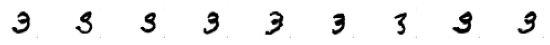

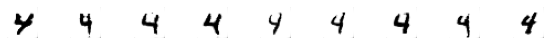

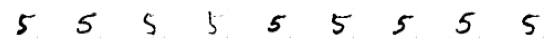

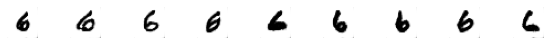

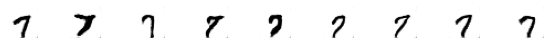

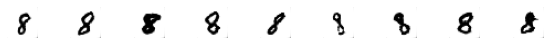

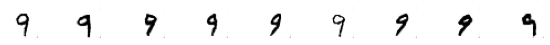

Epoch:20, Step:0, D-Loss:0.245, D-Acc:88.000, G-Loss:4.051
Epoch:20, Step:50, D-Loss:0.183, D-Acc:93.000, G-Loss:0.958
Epoch:20, Step:100, D-Loss:0.266, D-Acc:87.000, G-Loss:1.627
Epoch:20, Step:150, D-Loss:0.219, D-Acc:95.000, G-Loss:0.258
Epoch:20, Step:200, D-Loss:0.161, D-Acc:96.000, G-Loss:3.476
Epoch:20, Step:250, D-Loss:0.242, D-Acc:89.000, G-Loss:0.530
Epoch:20, Step:300, D-Loss:0.290, D-Acc:88.000, G-Loss:0.276
Epoch:20, Step:350, D-Loss:0.184, D-Acc:92.000, G-Loss:1.000
Epoch:20, Step:400, D-Loss:0.277, D-Acc:90.000, G-Loss:4.772
Epoch:20, Step:450, D-Loss:0.224, D-Acc:89.000, G-Loss:3.523
Epoch:21, Step:0, D-Loss:0.211, D-Acc:90.000, G-Loss:2.856
Epoch:21, Step:50, D-Loss:0.221, D-Acc:92.000, G-Loss:4.513
Epoch:21, Step:100, D-Loss:0.258, D-Acc:90.000, G-Loss:1.063
Epoch:21, Step:150, D-Loss:0.219, D-Acc:93.000, G-Loss:6.455
Epoch:21, Step:200, D-Loss:0.343, D-Acc:87.000, G-Loss:5.735
Epoch:21, Step:250, D-Loss:0.296, D-Acc:88.000, G-Loss:5.063
Epoch:21, Step:300, D-Loss:0.3

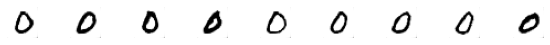

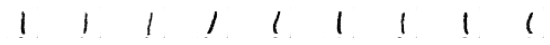

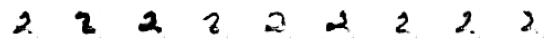

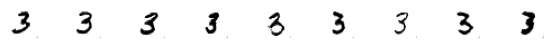

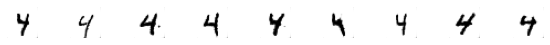

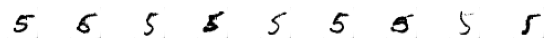

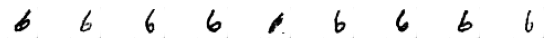

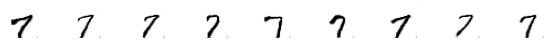

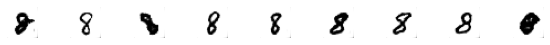

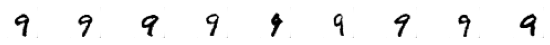

Epoch:25, Step:0, D-Loss:0.286, D-Acc:90.000, G-Loss:1.307
Epoch:25, Step:50, D-Loss:0.275, D-Acc:89.000, G-Loss:8.094
Epoch:25, Step:100, D-Loss:0.266, D-Acc:88.000, G-Loss:0.486
Epoch:25, Step:150, D-Loss:0.291, D-Acc:92.000, G-Loss:4.407
Epoch:25, Step:200, D-Loss:0.214, D-Acc:96.000, G-Loss:0.274
Epoch:25, Step:250, D-Loss:0.272, D-Acc:87.000, G-Loss:0.009
Epoch:25, Step:300, D-Loss:0.243, D-Acc:91.000, G-Loss:4.021
Epoch:25, Step:350, D-Loss:0.325, D-Acc:89.000, G-Loss:1.221
Epoch:25, Step:400, D-Loss:0.318, D-Acc:86.000, G-Loss:1.419
Epoch:25, Step:450, D-Loss:0.313, D-Acc:89.000, G-Loss:1.444
Epoch:26, Step:0, D-Loss:0.282, D-Acc:88.000, G-Loss:2.718
Epoch:26, Step:50, D-Loss:0.254, D-Acc:90.000, G-Loss:1.832
Epoch:26, Step:100, D-Loss:0.282, D-Acc:88.000, G-Loss:7.685
Epoch:26, Step:150, D-Loss:0.279, D-Acc:89.000, G-Loss:0.442
Epoch:26, Step:200, D-Loss:0.286, D-Acc:86.000, G-Loss:6.150
Epoch:26, Step:250, D-Loss:0.215, D-Acc:92.000, G-Loss:3.045
Epoch:26, Step:300, D-Loss:0.2

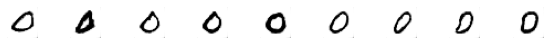

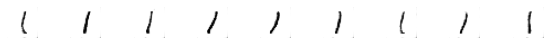

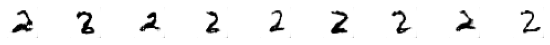

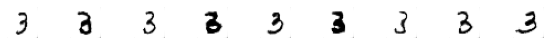

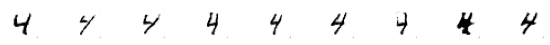

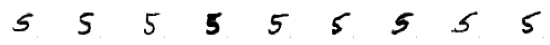

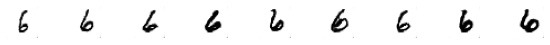

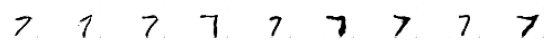

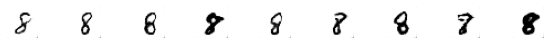

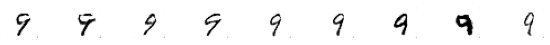

Epoch:30, Step:0, D-Loss:0.236, D-Acc:91.000, G-Loss:0.104


KeyboardInterrupt: ignored

In [16]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 100

for i in range(0, epochs):
    if (i%5 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch_part1 = np.vstack((fake_samples[0], real_samples[0]))
        input_batch_part2 = np.vstack((fake_samples[1], real_samples[1]))
        
        input_batch_final = [input_batch_part1, input_batch_part2]
        
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch_final, output_labels)
        
        noise_batches, class_values = get_random_noise(batch_size, noise_size)
        gan_input = [noise_batches, class_values]
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = gan_model.train_on_batch(gan_input, gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))
            

# Results

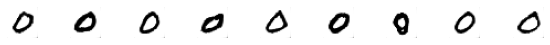

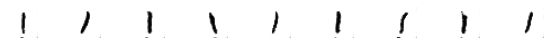

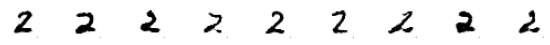

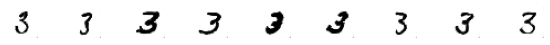

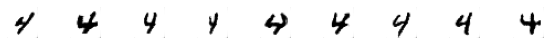

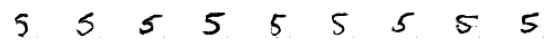

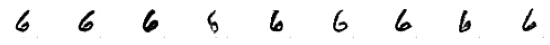

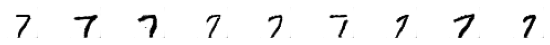

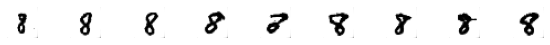

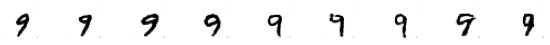

----------------------------------------------------------------------------------------------------


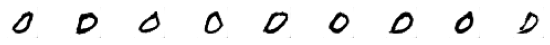

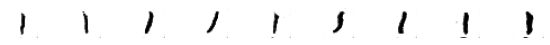

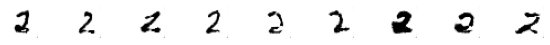

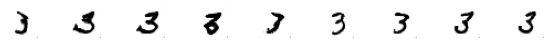

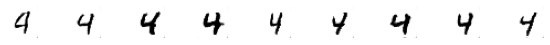

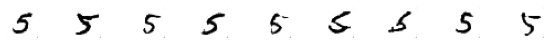

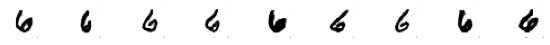

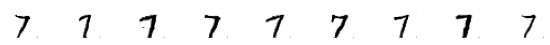

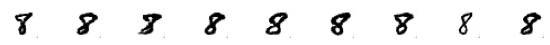

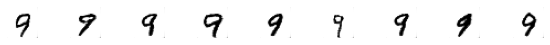

----------------------------------------------------------------------------------------------------


In [17]:
#Generating Unlimited samples
for i in range(2):
    show_generator_results(generator_network)
    print ("-"*100)